In [5]:
import numpy as np
import os


def step_source(t):
    # return 0.0
    # return np.exp(-0.5 * ((t - 0.005) / 0.0001) ** 2) if t < 0.01 else 0.0
    #return np.sin((np.pi / 0.01) * t) ** 4 if t < 0.01 else 0.0
    return 100.0 * (t < 0.01).astype(np.float32)

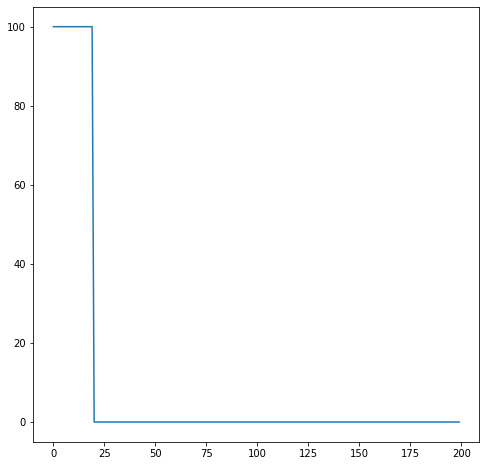

In [6]:
import matplotlib.pyplot as plt

start_time = 0.
end_time   = 0.1

plt.figure(figsize=(8, 8))
plt.plot(step_source(np.linspace(start_time, end_time, 200)))
plt.show()

In [9]:
import sympy as sym
sym.init_printing()

def get_elastic_matrices(Cp, Cs, Rho):

    var_rho   = Rho
    var_lmbda = (Cp ** 2. - 2. * Cs ** 2) * var_rho
    var_mu    = Cs ** 2. * var_rho

    lmbda, mu, rho =  sym.symbols('\lambda \mu \rho')

    elastic_x = sym.Matrix([
        [0., 0., 1/rho, 0., 0.],
        [0., 0., 0., 0., 1/rho],
        [lmbda + 2 * mu, 0., 0., 0., 0.],
        [lmbda, 0., 0., 0., 0.],
        [0., mu, 0., 0., 0.],
    ])

    elastic_y = sym.Matrix([
        [0., 0., 0., 0., 1/rho],
        [0., 0., 0., 1/rho, 0.],
        [0., lmbda, 0., 0., 0.],
        [0., lmbda + 2 * mu, 0., 0., 0.],
        [mu, 0., 0., 0., 0.],
    ])


    P1, D1 = elastic_x.diagonalize()
    P2, D2 = elastic_y.diagonalize()

    Ux, Sx, Ux1  = np.zeros((*cp.shape, 5, 5)), np.zeros((*cp.shape, 5, 5)), np.zeros((*cp.shape, 5, 5))
    Uy, Sy, Uy1  = np.zeros((*cp.shape, 5, 5)), np.zeros((*cp.shape, 5, 5)), np.zeros((*cp.shape, 5, 5))
    
    
    for i, (p1, d1, p11) in enumerate(zip(P1, D1, P1.inv())):
        
        # TODO: fill in the gaps
        Ux[:, :, i//5,i%5]  = None 
        Sx[:, :, i//5,i%5]  = None
        Ux1[:, :, i//5,i%5] = None

    for i, (p2, d2, p21) in enumerate(zip(P2, D2, P2.inv())):
        
        # TODO: fill in the gaps
        Uy[:, :, i//5,i%5]  = None
        Sy[:, :, i//5,i%5]  = None
        Uy1[:, :, i//5,i%5] = None

    return None

In [4]:
class elastics_solver():
    
    def __init__(
        self, 
        x_size, y_size, 
        cp, cs, rho, 
        target_time, 
        recording_time_step,
        source_coords,
        source_function = step_source,
        dump_vtk = False, 
        dump_dir = "data", 
        verbose = False
    ):

        assert (cp.shape == rho.shape)

        self.dump_vtk = dump_vtk
        self.dump_dir = dump_dir
        self.verbose = verbose
    
        self.x_size = x_size
        self.y_size = y_size
        
        
        self.num_points_x, self.num_points_y = cp.shape
        self.hx = self.x_size / (self.num_points_x - 1)
        self.hy = self.y_size / (self.num_points_y - 1)

        # required for numerical stability
        assert (abs(self.hx - self.hy) < 0.01 * (self.hx + self.hy))

        self.cp = cp
        self.cs = cs
        self.rho = rho
        
        # self.K = np.square(self.cp) * self.rho

        self.T = 0

        max_cp = np.max(self.cp)
        numerical_method_recommended_tau = 0.45 * min(self.hx / max_cp, self.hy / max_cp)

        if self.verbose:
            print("Numerical time step recommendation:", numerical_method_recommended_tau)

        self.number_of_records = int(target_time / recording_time_step)
        self.steps_per_record = max(int(recording_time_step / numerical_method_recommended_tau), 1)
        self.tau = recording_time_step / self.steps_per_record

        if self.verbose:
            print("Doing %d data records, %d steps per record, total %d steps, time step is %f, final time %f" %
                  (self.number_of_records, self.steps_per_record,
                   self.number_of_records * self.steps_per_record, self.tau, target_time))

        self.x = np.linspace(0.0, self.x_size, self.num_points_x, endpoint=True)
        self.y = np.linspace(0.0, self.y_size, self.num_points_y, endpoint=True)
        self.z = np.array([0.0])

        if self.dump_vtk:
            from pyevtk.hl import gridToVTK
            gridToVTK(os.path.join(self.dump_dir, "params"), self.x, self.y, self.z,
                      pointData = {"Cp" : self.cp.T.ravel(), "rho" : self.rho.T.ravel(), "K" : self.K.T.ravel()})

        source_half_width_in_points = int(source_width / (2 * self.hx))
        source_center_idx = int(self.num_points_x * source_center_in_percents / 100)
        self.source_start_point = source_center_idx - source_half_width_in_points
        self.source_end_point = source_center_idx + source_half_width_in_points

        self.source = source_function
        if self.verbose:
            print("Grid shape", cp.shape)
            print("The source is located from %d to %d" % (self.source_start_point, self.source_end_point))
            
    
    def do_split_step(self, u_prev, U, U1, c_neg, c_pos, direction = -1):
        
        # TODO: implement explicit time-stepping using NumPy
        
        raise NotImplementedError
    
    def forward(self):
        
        # TODO: implement forward wave propagation using space-split scheme
        # We are referring to https://keldysh.ru/council/3/D00202403/kazakov_ao_diss.pdf
        # as our basis
        
        raise NotImplementedError
